In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm.notebook import tqdm, trange
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from model.CustomDataSet import CustomDataSetRNN, SimpleDataSet
from model.Tokenizer import SimpleTokenizerV1
from model.TokenDrop import TokenDrop, TokenDropOdd, TokenDropEven
from model.RNN import *
from environnement.gridWorld import gridWorld
from outil import *

In [2]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
device = "cpu" # Pour forcer l'utilisation du CPU

# Data

In [3]:
def get_data(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

def get_data_without(env:env, tokenizer:SimpleTokenizerV1, acts:list[str] , n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    all_action = [element for element in all_action if element not in acts]
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


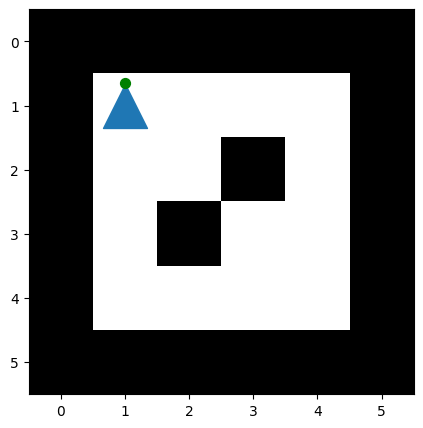

In [4]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

# Tokenizer

In [5]:
list_vocab = ['<pad>']
for act in env_test.get_actions():
    list_vocab.append(act)
for fb in env_test.get_outcomes():
    list_vocab.append(fb)    
tmp = create_dico_numerate_word(list_vocab)
tokenizer = SimpleTokenizerV1(vocab=tmp)

# X and Y

## Chaque séquence est complètement indépendante
### Res :
Spoil : au moins a partir de 500, > 95% d'acc (50 epoch) Attention on comptant les "turn"

In [6]:
data_brut_y=[]
for i in range(700):
    data_brut_y.append(get_data(env_test, tokenizer, n_episodes=50))

data_y = torch.tensor(data_brut_y)
data_loader = DataLoader(data_y, batch_size=16, shuffle=True)


## Une grande séquence découper

In [7]:
data_brut = get_data(env_test, tokenizer, n_episodes=1000)
print(data_brut)
def decoup_seq(seq:list, size:int, overlap:int=1):
    """
    Decoupe une sequence en sous-sequence de taille size
    """
    return [seq[i:i+size] for i in range(0, len(seq) - size +1, overlap)]

data_decoup = decoup_seq(seq=data_brut, size=30, overlap=10)
print(data_decoup)
data_decoup = torch.tensor(data_decoup)
data_loader_decoup = DataLoader(data_decoup, batch_size=16, shuffle=True)

[6, 8, 4, 7, 1, 7, 6, 8, 2, 8, 2, 8, 4, 8, 1, 8, 1, 7, 3, 8, 6, 8, 1, 8, 6, 8, 4, 7, 2, 8, 3, 8, 4, 7, 1, 7, 2, 8, 6, 7, 4, 8, 6, 7, 3, 8, 1, 7, 2, 8, 4, 8, 2, 8, 1, 8, 4, 7, 2, 8, 3, 8, 4, 7, 5, 8, 6, 7, 5, 8, 4, 7, 4, 7, 6, 7, 2, 8, 2, 8, 1, 8, 1, 7, 2, 8, 2, 8, 1, 8, 4, 7, 3, 8, 1, 7, 3, 8, 3, 8, 4, 8, 5, 8, 6, 7, 2, 8, 3, 8, 4, 8, 6, 7, 5, 8, 4, 8, 6, 7, 5, 8, 5, 8, 3, 8, 6, 7, 6, 7, 5, 8, 2, 8, 4, 8, 1, 8, 3, 8, 5, 7, 4, 8, 6, 8, 2, 8, 5, 8, 3, 8, 1, 8, 5, 7, 1, 8, 2, 8, 3, 8, 3, 8, 4, 8, 2, 8, 2, 8, 1, 7, 2, 8, 6, 7, 5, 8, 4, 8, 1, 8, 6, 7, 1, 8, 6, 7, 4, 8, 2, 8, 3, 8, 5, 8, 4, 8, 5, 8, 4, 8, 5, 8, 5, 8, 2, 8, 6, 8, 2, 8, 2, 8, 1, 7, 6, 8, 6, 8, 6, 8, 3, 8, 3, 8, 2, 8, 5, 7, 1, 8, 4, 8, 4, 8, 1, 8, 1, 7, 3, 8, 3, 8, 1, 8, 3, 8, 4, 7, 2, 8, 4, 8, 5, 7, 3, 8, 4, 7, 2, 8, 3, 8, 4, 7, 2, 8, 4, 8, 4, 8, 5, 7, 5, 7, 2, 8, 4, 7, 3, 8, 3, 8, 1, 7, 2, 8, 5, 7, 6, 7, 5, 7, 6, 7, 4, 8, 4, 8, 4, 8, 4, 8, 5, 7, 4, 8, 4, 8, 6, 7, 1, 8, 4, 8, 3, 8, 2, 8, 2, 8, 6, 8, 4, 8, 3, 8, 5, 8, 6, 7, 3, 

data_y est alors notre Y. Pour obtenir notre X, nous utiliserons un token Dropen

Notre x est donc data_x. Maintenant nous voulons que notre model arrive à obvenir un représentation de la séquence pour réussir a compléter les 0.

# Multi tasks ?
On peut vouloir un encoder qui apprend a encoder pour deviner les actions, et un encoder qui apprends a deviner les observations.


In [8]:
data_set = SimpleDataSet(data_brut_y)

print("len data_set", data_set.__len__())
print("data_set 1", data_set[0])

tensor([[1, 7, 6,  ..., 8, 1, 8],
        [2, 8, 1,  ..., 8, 6, 7],
        [4, 8, 6,  ..., 8, 4, 8],
        ...,
        [4, 7, 2,  ..., 7, 6, 7],
        [3, 8, 6,  ..., 7, 5, 7],
        [6, 8, 1,  ..., 8, 3, 8]])
len data_set 100
data_set 1 tensor([1, 7, 6, 8, 4, 7, 1, 7, 5, 7, 3, 8, 3, 8, 6, 7, 5, 8, 3, 8, 2, 8, 1, 8,
        6, 7, 4, 8, 6, 7, 6, 7, 3, 8, 4, 7, 5, 8, 1, 7, 5, 8, 5, 8, 6, 8, 2, 8,
        3, 8, 5, 8, 2, 8, 5, 8, 3, 8, 1, 7, 3, 8, 6, 8, 3, 8, 1, 8, 3, 8, 2, 8,
        5, 8, 3, 8, 6, 8, 3, 8, 4, 8, 4, 8, 1, 8, 4, 7, 3, 8, 3, 8, 2, 8, 3, 8,
        4, 8, 1, 8])


In [ ]:
def fit(model, nb_epoch:int, data_loader:DataLoader, optimizer, loss_fn):
    """
    train model
    """
    acc_train = []
    loss_train = []
    
    for i in trange(nb_epoch, desc=f"Training ", unit="epoch"):
        model.train()
        steps = 0
        train_acc = 0
        training_loss = []
        for tmp, data in enumerate(data_loader):
            # x is data[:-1]
            # t is data[-1]
            x = data[:, :-1]
            x = x.to(device)
            t = data[:, -1]
            # t - 8
            t = t - 7
            t = t.to(device)
            bs = t.shape[0]
            h = torch.zeros(model.num_layers, bs, model.hidden_size, device=device)
            cell = torch.zeros(model.num_layers, bs, model.hidden_size, device=device)

            pred, h, cell = model(x, h, cell)

            loss = loss_fn(pred[:, -1, :], t)
            training_loss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_acc += sum((pred[:, -1, :].argmax(1) == t).cpu().numpy())
            steps += bs
        
        acc_train.append(train_acc / steps)
        loss_means /= len(loss_means)
        loss_train.append(training_loss)
        # If acc is 100% we stop the training
        # if acc_train[-1] >= 0.99:
        #     for _ in range(i, nb_epoch):
        #         acc_train.append(acc_train[-1])
        #     break
        tqdm.write(f"Epoch {j + 1}/{nb_epoch}, Loss: {loss_train[-1]}, Accuracy: {acc_train[-1]}")
    return acc_train, loss_train

In [10]:
# num_layers = 1
# hidden_size = 128
# temp = 1.0
# model = LSTM_representation(
#     num_emb=len(list_vocab),
#     hidden_size=hidden_size,
#     emb_size=hidden_size,
#     num_layers=num_layers,
#     dropout=0.1
# )

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_fn = nn.CrossEntropyLoss()

In [11]:
# train(
#     model=model,
#     data_loader_train=data_loader,
#     nb_epoch=100,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     pourcentTokenDrop=0.15
# )

In [16]:
num_layers = 2
hidden_size = 256
model_fb = LSTM_Classifeur(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    output_size=len(env_test.get_outcomes()),
    num_layers=num_layers,
).to(device)

optimizer_fb = optim.Adam(model_fb.parameters())
loss_fn_fb = nn.CrossEntropyLoss()

list_acc, list_loss = fit(
    model=model_fb,
    data_loader=data_loader,
    nb_epoch=50,
    optimizer=optimizer_fb,
    loss_fn=loss_fn_fb
)


In [ ]:
end

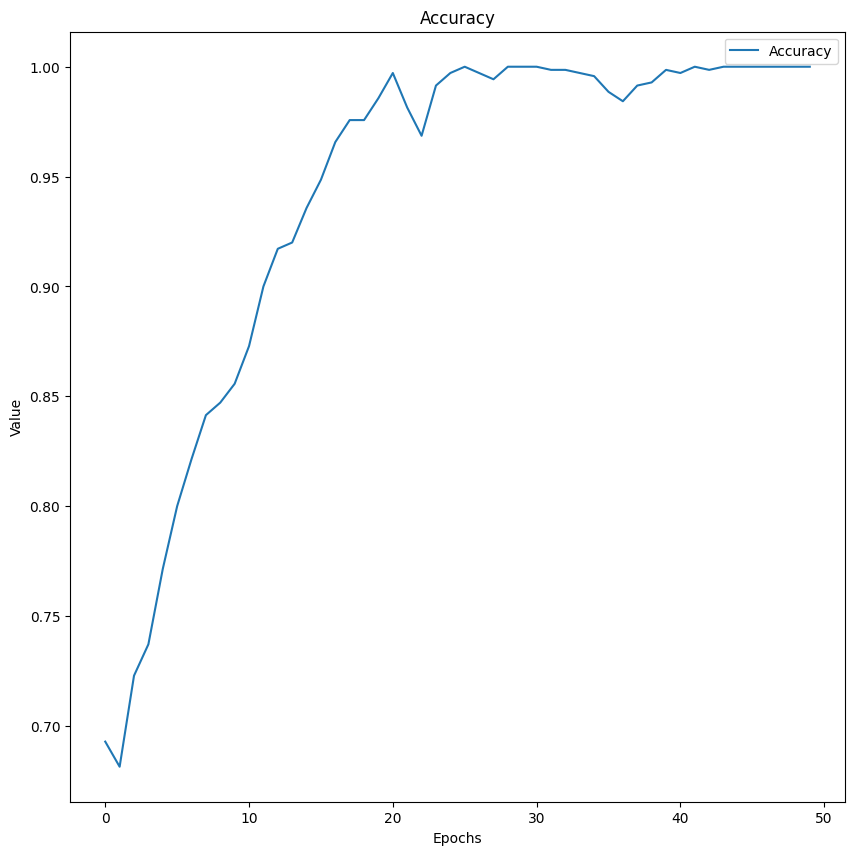

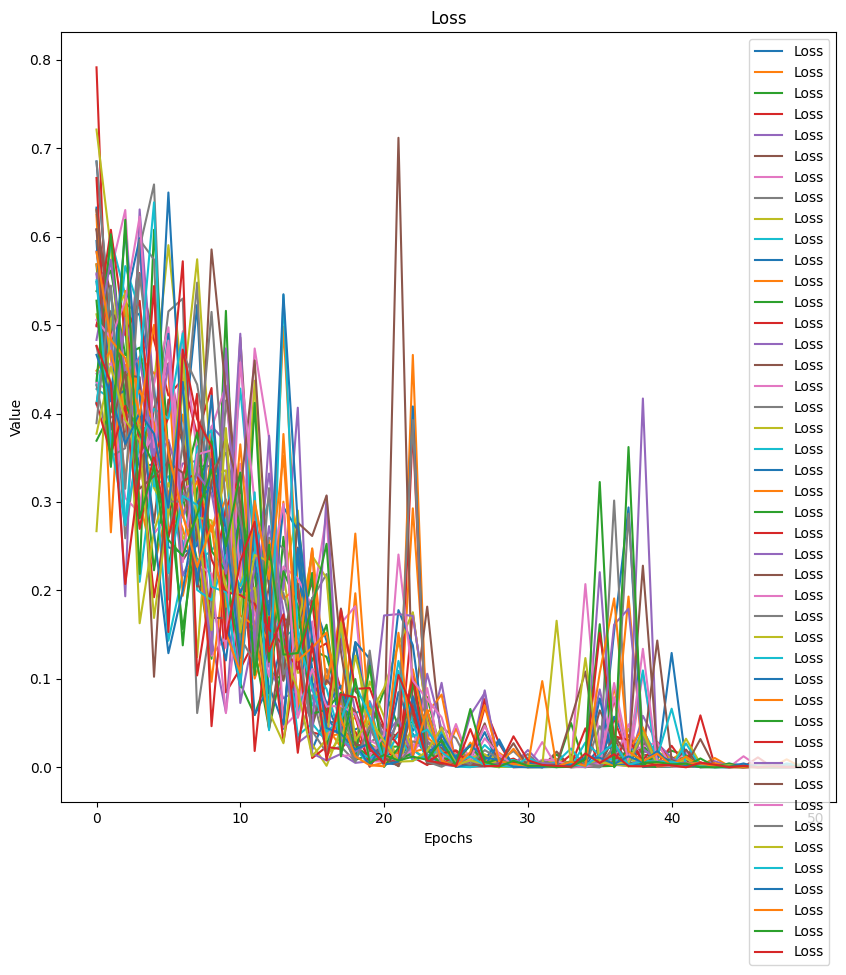

In [20]:
# Plot
plt.figure(figsize=(10, 10))
# plt.plot(list_loss, label='Loss')
plt.plot(list_acc, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
# plt.plot(list_loss, label='Loss')
plt.plot(list_loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Loss')
plt.legend()
plt.show()

In [21]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x = []
data_test_y = []
data_infos = []
for i in range(20000):
    # range_context = np.random.randint(10, 20)
    range_context = 20
    last_act = "turn_left"
    while last_act == "turn_left" or last_act == "turn_right":
        sequence = get_data(env_test, tokenizer, n_episodes=range_context)
        last_act = tokenizer.decode(sequence[-2])
            
    data_test_x.append(sequence[:-1] + [0])    
    data_test_y.append(sequence[-1])
    
    data_infos.append({
        "sequence": sequence,
        "coo": env_test.get_coo(),
        "theta": env_test.get_theta(),
        "last_act": last_act,
        "last_feedback": tokenizer.decode(sequence[-1]),
        "info_in_sequence": bool(info_in_seq(tokenizer.decode(data_test_x[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test.outcome(feel)
        data_infos[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y:
    if i == 8:
        count_8 += 1
    elif i == 7:
        count_7 += 1
print(f"count_8 {tokenizer.decode(8)}", count_8)
print(f"count_7 {tokenizer.decode(7)}", count_7)

print("data_infos", data_infos[0])
print("x ", data_test_x[0])
print("y ", data_test_y[0])

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
count_8 empty 10108
count_7 wall 9892
data_infos {'sequence': [3, 8, 2, 8, 6, 8, 6, 8, 5, 7, 3, 8, 3, 8, 1, 8, 3, 8, 6, 8, 1, 7, 6, 8, 5, 8, 4, 7, 4, 7, 2, 8, 3, 8, 6, 8, 1, 7, 5, 8], 'coo': (1, 2), 'theta': 3, 'last_act': 'feel_left', 'last_feedback': 'empty', 'info_in_sequence': True, 'feel_front': 'wall', 'feel_left': 'empty', 'feel_right': 'empty'}
x  [3, 8, 2, 8, 6, 8, 6, 8, 5, 7, 3, 8, 3, 8, 1, 8, 3, 8, 6, 8, 1, 7, 6, 8, 5, 8, 4, 7, 4, 7, 2, 8, 3, 8, 6, 8, 1, 7, 5, 0]
y  8


In [ ]:
for key, value in data_infos[56].items():
    print(f"{key}: {value}")


sequence: [3, 8, 6, 8, 2, 8, 1, 7, 4, 7, 2, 8, 1, 8, 6, 7, 2, 8, 3, 8, 4, 8, 2, 8, 1, 7, 2, 8, 4, 8, 1, 8, 6, 8, 5, 7, 1, 8, 4, 7]
coo: (4, 4)
theta: 2
last_act: feel_front
last_feedback: wall
info_in_sequence: False
feel_front: wall
feel_left: wall
feel_right: empty


In [22]:
length = max(len(xi) for xi in data_test_x)
data_test_x_tensor = torch.zeros((len(data_test_x), length), dtype=torch.long)
for i, xi in enumerate(data_test_x):
    data_test_x_tensor[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor = torch.tensor(data_test_y, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

data_loader_test = DataLoader(CustomDataset(data_test_x_tensor, data_test_y_tensor, data_infos), batch_size=1, shuffle=False)

for i, (data_x, data_y, info) in enumerate(data_loader_test):
    print(data_x)
    print(data_y)
    for key, value in info.items():
        print(f"{key}: {value}")
    break

tensor([[3, 8, 2, 8, 6, 8, 6, 8, 5, 7, 3, 8, 3, 8, 1, 8, 3, 8, 6, 8, 1, 7, 6, 8,
         5, 8, 4, 7, 4, 7, 2, 8, 3, 8, 6, 8, 1, 7, 5, 0]])
tensor([8])
sequence: [tensor([3]), tensor([8]), tensor([2]), tensor([8]), tensor([6]), tensor([8]), tensor([6]), tensor([8]), tensor([5]), tensor([7]), tensor([3]), tensor([8]), tensor([3]), tensor([8]), tensor([1]), tensor([8]), tensor([3]), tensor([8]), tensor([6]), tensor([8]), tensor([1]), tensor([7]), tensor([6]), tensor([8]), tensor([5]), tensor([8]), tensor([4]), tensor([7]), tensor([4]), tensor([7]), tensor([2]), tensor([8]), tensor([3]), tensor([8]), tensor([6]), tensor([8]), tensor([1]), tensor([7]), tensor([5]), tensor([8])]
coo: [tensor([1]), tensor([2])]
theta: tensor([3])
last_act: ['feel_left']
last_feedback: ['empty']
info_in_sequence: tensor([True])
feel_front: ['wall']
feel_left: ['empty']
feel_right: ['empty']


In [25]:
model_fb.eval()
acc = 0

data_frame_seq = pd.DataFrame({
    "seq": [""] * len(data_loader_test),
    "seq_dec": [""] * len(data_loader_test),
    "prediction": [""] * len(data_loader_test),
    "prediction_dec": [""] * len(data_loader_test),
    "reality": [""] * len(data_loader_test),
    "reality_dec": [""] * len(data_loader_test),
    "probability": [""] * len(data_loader_test),
    "good_prediction": [False] * len(data_loader_test),
    "info_in_seq": [False] * len(data_loader_test),
    "info_feel_left": [False] * len(data_loader_test),
    "info_feel_front": [False] * len(data_loader_test),
    "info_feel_right": [False] * len(data_loader_test),
    "coo_xy": [""] * len(data_loader_test),
    "theta": [-1] * len(data_loader_test),
    "state_left": [""] * len(data_loader_test),
    "state_front": [""] * len(data_loader_test),
    "state_right": [""] * len(data_loader_test),
    
})

# data_frame_seq = data_frame_seq.astype({
#     "seq": "object",
#     "prediction": "U20",
#     "reality": "object",
#     "probability": "object",
#     "good_prediction": "bool",
#     "info_in_seq": "bool",
#     "info_feel_left": "bool",
#     "info_feel_front": "bool",
#     "info_feel_right": "bool",
#     "coo_xy": "object",
#     "theta": "int64"
# })

with torch.no_grad():
    for i, (input, target, info) in tqdm(enumerate(data_loader_test)):
        input = input.to(device)
        target = target.to(device)
        target = target - 7
        h = torch.zeros(model_fb.num_layers , 1, model_fb.hidden_size).to(device)
        cell = torch.zeros(model_fb.num_layers, 1, model_fb.hidden_size).to(device)
        output, h, cell = model_fb(input, h, cell)
        
        arrays, x, y, theta = process_sequence(tokenizer.decode(input.tolist()[0]), 6, None)
        good_seq = info_in_memory(arrays)
        feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
        
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        acc += (pred[-1][-1] == target).item()
        state_left = info["feel_left"][0]
        state_front = info["feel_front"][0]
        state_right = info["feel_right"][0]
        coo = (info["coo"][0].item(), info["coo"][1].item())
        theta = info["theta"][0].item()

        data_frame_seq.loc[i] = [
            str(input.tolist()[0]),
            str(tokenizer.decode(input.tolist()[0])),
            str(pred.tolist()[0][-1]),
            str(tokenizer.decode(pred.tolist()[0][-1])),
            target.tolist()[0],
            tokenizer.decode(target.tolist()[0]),
            str(proba.tolist()[-1][-1][-2:]),
            (pred[-1][-1] == target).item(),
            good_seq,
            feel_left,
            feel_front,
            feel_right,
            str(coo),
            theta,
            state_left,
            state_front,
            state_right
        ]
print(f"Accuracy: {acc / 20000}")

0it [00:00, ?it/s]

Accuracy: 0.6025


In [ ]:
# keep only row with good_prediction = True
data_frame_seq_success = data_frame_seq.loc[data_frame_seq["good_prediction"]]

# Résultat

0.96 % d'accuracy  

data test est constituer de 82% sequence dont l'information/feedback demandé a été vue  

Sur la partie où l’information n'est pas dans la séquence, l'accuracy tombe à 83%  

Sur la partie où l’information est dans la séquence, l'accuracy monte à 99%

## Not same environment
Quand il n'y a pas le même environment (autre grille) entre le train et le teste, 
acc = 83%
  
Si nous prenons que les seq avec infos alors on passe à 97% 

## Big context
0.97 % 
92% on une séquence avec une infos
sinon même stats

# Embeding

In [ ]:
model_fb.eval()
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
print("hidden_in", hidden_in.shape)
print("mem_in", mem_in.shape)
all_hidden = []
all_mem = []
all_output_1 = []
all_output_2 = []

# for x, y, info in zip(data_test_x, data_test_y, data_infos):
#     input_seq = torch.tensor(x).to(device)
#     output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))
#     all_hidden.append(hidden_out[-1])
#     all_mem.append(mem_out[-1])
#     all_output_1.append(output[-1])
#     all_output_2.append(output[29])

# keep only data_frame_seq(data frame) with feel_left, feel_front, feel_right
data_infos_success = data_frame_seq.loc[
    # (data_frame_seq["info_feel_left"]) & 
    # (data_frame_seq["info_feel_front"]) & 
    # (data_frame_seq["info_feel_right"]) &
    # (data_frame_seq["good_prediction"])
    (data_frame_seq["info_in_seq"])
]
print("data_infos_success", len(data_infos_success))

# data_infos_sucess = [d for d in data_infos if all(d["feel_left", "feel_front", "feel_right"])]
for sequence in data_infos_success["seq"]:
    sequence = eval(sequence)
    input_seq = torch.tensor(sequence).to(device)
    output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))
    all_hidden.append(hidden_out[-1])
    all_mem.append(mem_out[-1])
    all_output_1.append(output[-1])
    all_output_2.append(output[-3])


# print("shape output", all_output_1[0].shape)

hidden_in torch.Size([4, 1, 256])
mem_in torch.Size([4, 1, 256])
data_infos_success 15361


In [ ]:
print(tokenizer.encode(["feel_front", "feel_left", "feel_right"]))

[4, 5, 6]


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_4201/1474131097.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_coo))
/tmp/ipykernel_4201/1474131097.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
/tmp/ipykernel_4

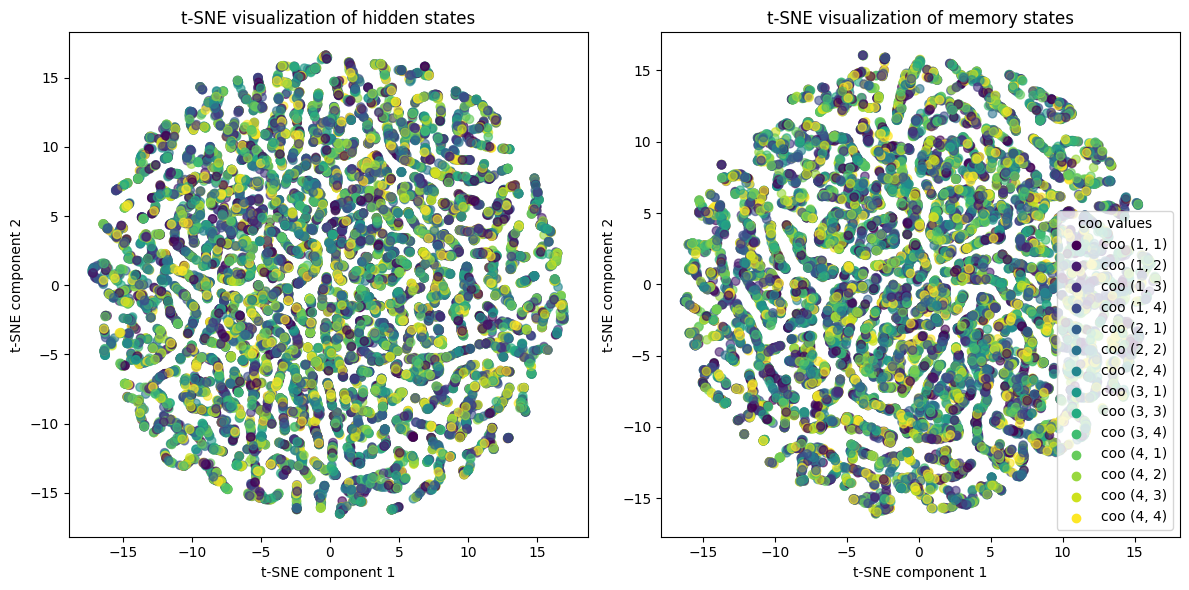

all_output_stack (15361, 512)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (15361, 2)


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)

coo_info = data_infos_success["coo_xy"].tolist()

unique_coo = np.unique(coo_info)
color_map = plt.cm.get_cmap('viridis', len(unique_coo))
coo_colors = [color_map(unique_coo.tolist().index(str(coo))) for coo in coo_info]

theta_info = data_infos_success["theta"].tolist()

unique_theta = np.unique(theta_info)
# Attribuer une former pour chaque valeur unique de theta
markers_list = ['o', 's', 'D', 'v', '^', '<', '>', 'P', 'X', '*']
markers_map = {theta: markers_list[i % len(markers_list)] for i, theta in enumerate(unique_theta)}
theta_markers = [markers_map[theta] for theta in theta_info]


plt.figure(figsize=(12, 6))

# Plot pour all_hidden_emb
plt.subplot(1, 2, 1)
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of hidden states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Plot pour all_mem_emb
plt.subplot(1, 2, 2)
plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of memory states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')

plt.tight_layout()
plt.show()
plt.close()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_1)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
for i in range(len(all_output_emb)):
    plt.scatter(all_output_emb[i, 0], all_output_emb[i, 1], c=[coo_colors[i]], marker=theta_markers[i], alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()
plt.close()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_2)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()
plt.close()

all_hidden torch.Size([15430, 256])
all_mem torch.Size([15430, 256])
all_hidden (15430, 256)
all_mem (15430, 256)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_hidden_emb (15430, 2)
all_mem_emb (15430, 2)
feel_info ['wa|em|wa', 'em|em|wa', 'em|wa|wa', 'em|wa|em', 'wa|em|em', 'wa|wa|em', 'em|wa|em', 'wa|wa|em', 'em|wa|em', 'wa|em|wa', 'wa|em|em', 'wa|em|em', 'em|wa|wa', 'em|wa|em', 'em|wa|wa', 'em|em|wa', 'em|wa|wa', 'em|wa|em', 'wa|em|em', 'wa|wa|em', 'wa|em|em', 'wa|wa|em', 'wa|wa|em', 'em|em|wa', 'wa|em|wa', 'wa|wa|em', 'em|wa|wa', 'em|em|wa', 'wa|em|wa', 'em|wa|wa', 'em|wa|em', 'em|wa|em', 'wa|wa|em', 'wa|em|wa', 'em|wa|em', 'em|wa|em', 'wa|wa|em', 'wa|wa|em', 'em|wa|em', 'em|wa|wa', 'wa|em|wa', 'wa|em|em', 'wa|em|em', 'wa|wa|em', 'wa|wa|em', 'wa|wa|em', 'em|em|wa', 'em|wa|em', 'em|wa|em', 'em|wa|em', 'em|wa|em', 'em|wa|em', 'wa|em|wa', 'em|em|wa', 'em|em|wa', 'wa|em|wa', 'em|em|wa', 'em|wa|em', 'em|wa|em', 'wa|wa|em', 'em|wa|em', 'wa|em|em', 'wa|em|wa', 'em|em|wa', 'wa|em|em', 'em|em|wa', 'em|em|wa', 'em|em|wa', 'em|em|wa', 'em|em|wa', 'wa|em|em', 'wa|em|wa', 'em|wa|wa', 'wa|em|em', 'wa|em|wa', 'wa|wa|em', 'wa|em|wa', 'em|wa|em', 'em|

/tmp/ipykernel_5086/1109148377.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_feel))
/tmp/ipykernel_5086/1109148377.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
/tmp/ipykernel_5086/1109148377.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)


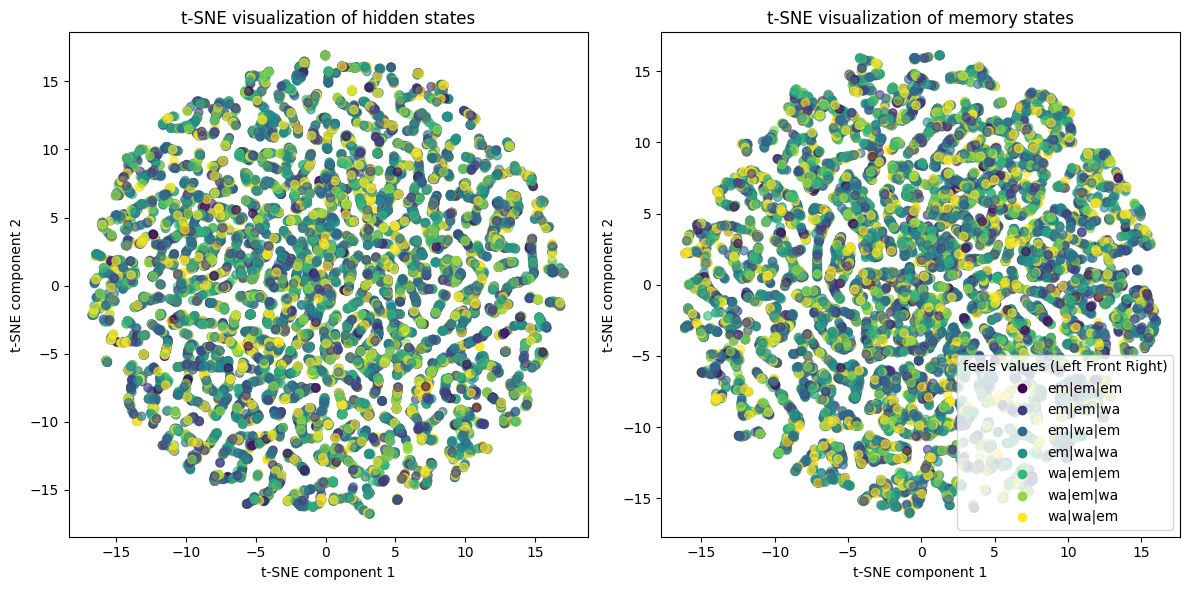

all_output_stack (15430, 512)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (15430, 2)


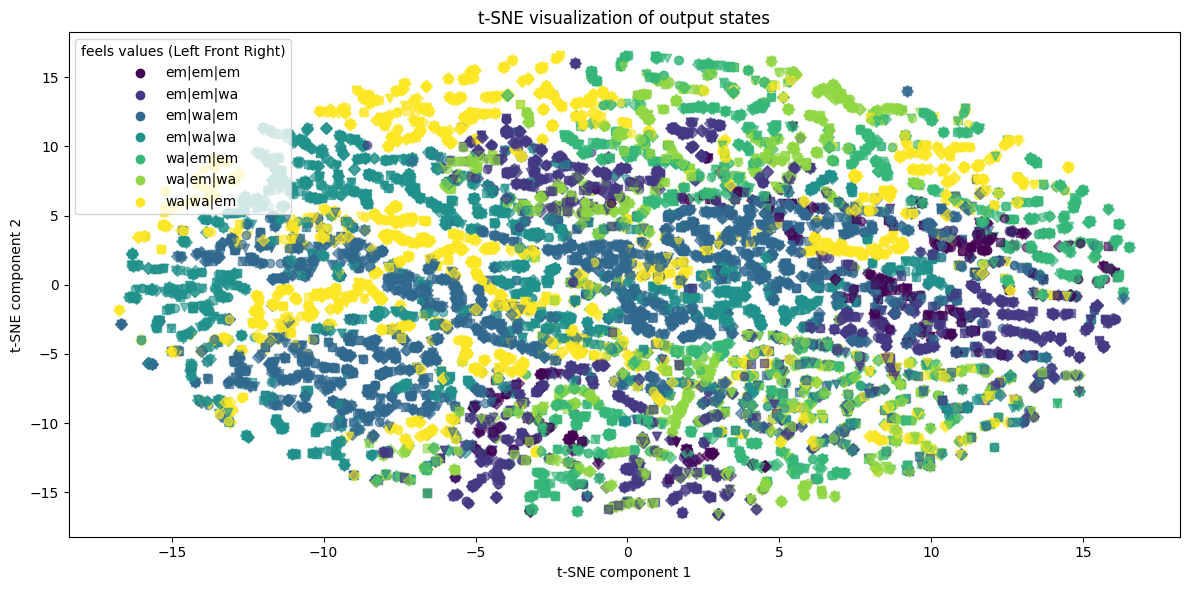

all_output_stack (15430, 512)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (15430, 2)


/tmp/ipykernel_5086/1109148377.py:72: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)


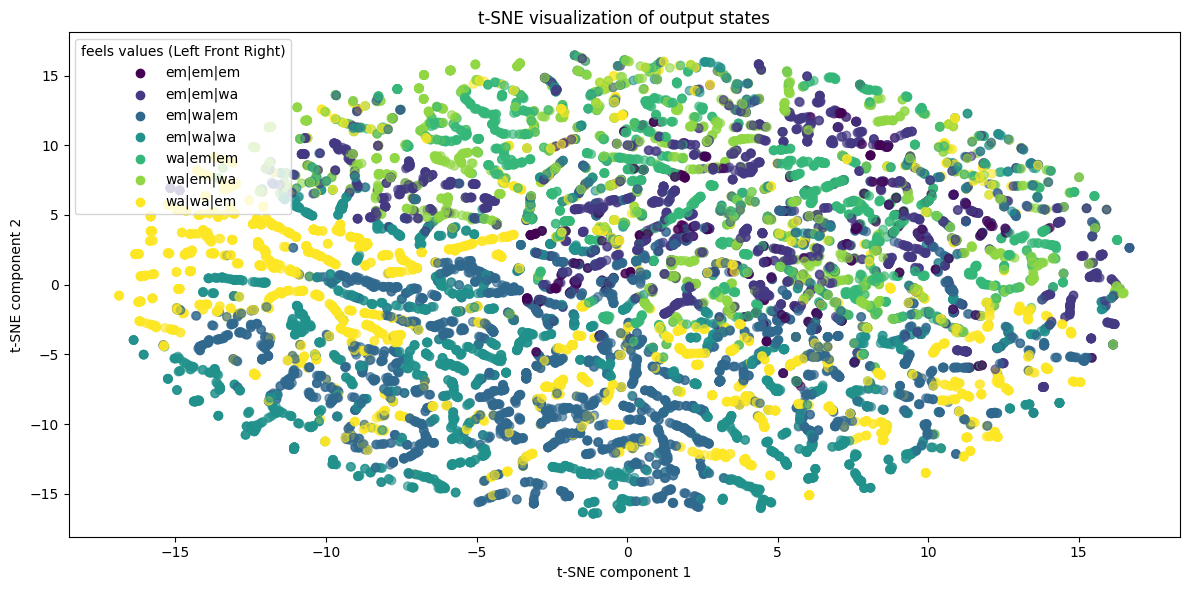

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
print("all_hidden_emb", all_hidden_emb.shape)
print("all_mem_emb", all_mem_emb.shape)

feel_info = [str(info[0][0:2]) + '|' + str(info[1][0:2]) + '|' + str(info[2][0:2]) for info in zip(data_infos_success["state_left"], data_infos_success["state_front"], data_infos_success["state_right"])]

print("feel_info", feel_info)
unique_feel = np.unique(feel_info)
print("unique_feel", unique_feel)
color_map = plt.cm.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]
plt.figure(figsize=(12, 6))
# Plot pour all_hidden_emb
plt.subplot(1, 2, 1)
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of hidden states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Plot pour all_mem_emb
plt.subplot(1, 2, 2)
plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of memory states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_1)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
for i in range(len(all_output_emb)):
    plt.scatter(all_output_emb[i, 0], all_output_emb[i, 1], c=[feel_colors[i]], marker=theta_markers[i], alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()


tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_2)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


act_pred ['forward | empty', 'feel_front | empty', 'feel_right | wall', 'feel_left | empty', 'feel_right | empty', 'forward | wall', 'feel_left | empty', 'forward | wall', 'feel_front | wall', 'feel_front | empty', 'feel_front | empty', 'feel_right | empty', 'forward | empty', 'feel_left | empty', 'feel_front | wall', 'feel_right | wall', 'feel_front | wall', 'feel_left | empty', 'feel_left | wall', 'feel_right | empty', 'feel_left | wall', 'feel_left | wall', 'feel_front | wall', 'feel_front | empty', 'feel_left | wall', 'feel_right | empty', 'feel_right | wall', 'feel_right | wall', 'feel_right | empty', 'forward | wall', 'feel_left | empty', 'feel_right | empty', 'forward | empty', 'feel_right | wall', 'feel_right | empty', 'feel_right | empty', 'feel_left | wall', 'feel_front | wall', 'feel_right | empty', 'forward | wall', 'forward | empty', 'feel_left | wall', 'feel_right | empty', 'feel_front | wall', 'feel_left | wall', 'feel_front | wall', 'forward | empty', 'feel_front | wall

/tmp/ipykernel_5086/2060518303.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_front = plt.cm.get_cmap('viridis', len(unique_front))
/tmp/ipykernel_5086/2060518303.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_left = plt.cm.get_cmap('viridis', len(unique_left))
/tmp/ipykernel_5086/2060518303.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_right = plt.cm.get_cmap('viridis', len(unique_feel))
/tmp/ipykernel_5086/20605

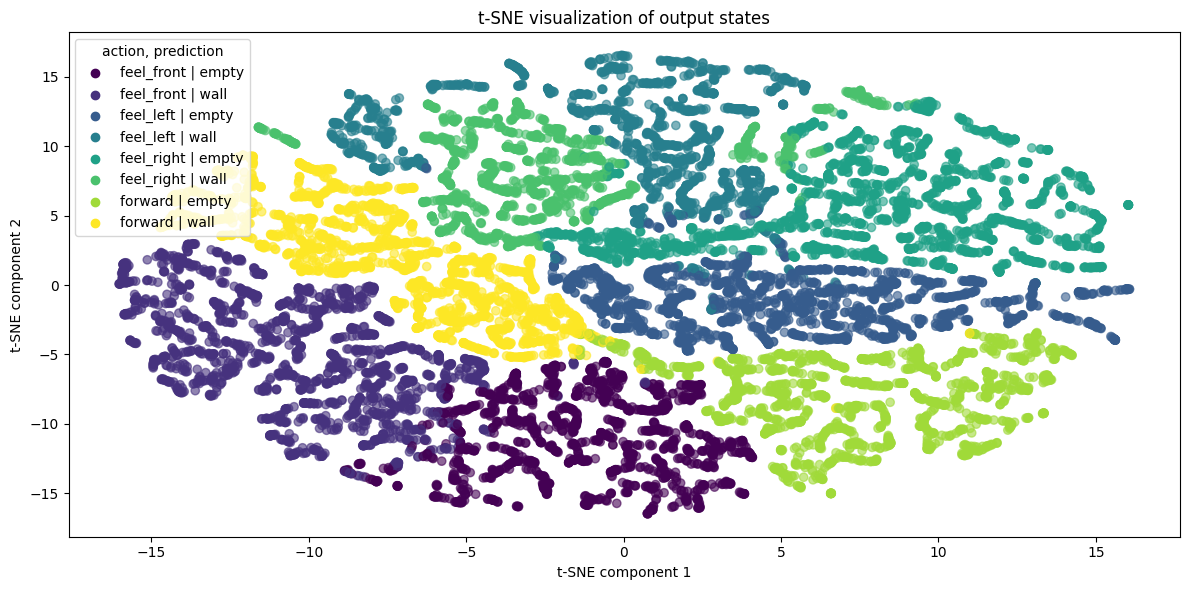

/tmp/ipykernel_5086/2060518303.py:57: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=act_colors, cmap='viridis', alpha=0.6)


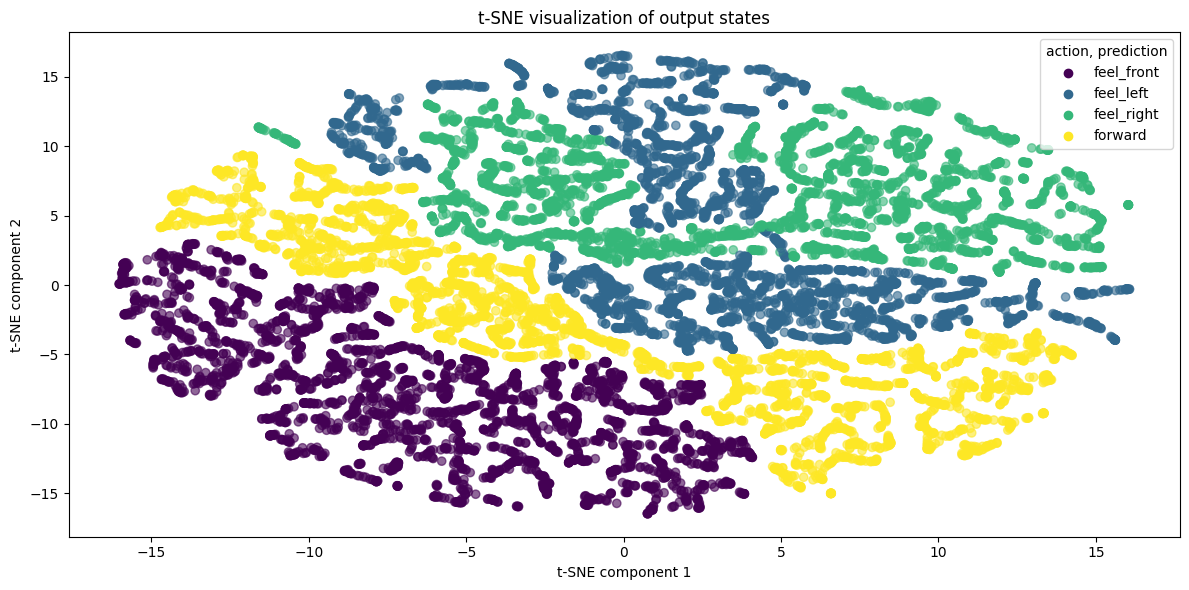

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_output_stack = torch.stack(all_output_1)

all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_output_stack = all_output_stack.detach().cpu().numpy()

all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
all_output_emb = tsne.fit_transform(all_output_stack)

front_info = [str(info) for info in data_infos_success["state_front"]]
left_info = [str(info) for info in data_infos_success["state_left"]]
right_info = [str(info) for info in data_infos_success["state_right"]]

act_pred = [str(eval(to_act)[-2]) + ' | ' +  pred for to_act, pred in zip(data_infos_success["seq_dec"], data_infos_success["prediction_dec"])]
act = [str(eval(to_act)[-2]) for to_act in data_infos_success["seq_dec"]]

print("act_pred", act_pred)

unique_front = np.unique(front_info)
unique_left = np.unique(left_info)
unique_right = np.unique(right_info)
unique_act_pred = np.unique(act_pred)
unique_act = np.unique(act)

color_map_front = plt.cm.get_cmap('viridis', len(unique_front))
front_colors = [color_map_front(unique_front.tolist().index(str(feel))) for feel in front_info]

color_map_left = plt.cm.get_cmap('viridis', len(unique_left))
left_colors = [color_map_left(unique_left.tolist().index(str(feel))) for feel in left_info]

color_map_right = plt.cm.get_cmap('viridis', len(unique_feel))
right_colors = [color_map_right(unique_right.tolist().index(str(feel))) for feel in right_info]

color_map_act_pred = plt.cm.get_cmap('viridis', len(unique_act_pred))
act_pred_colors = [color_map_act_pred(unique_act_pred.tolist().index(_act)) for _act in act_pred]

color_map_act = plt.cm.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.tolist().index(_act)) for _act in act]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=act_pred_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_act_pred, color_map_act_pred(np.arange(len(unique_act_pred)))):
    plt.scatter([], [], c=[color], label=f'{coo}')
plt.legend(title='action, prediction')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=act_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{coo}')
plt.legend(title='action, prediction')
plt.tight_layout()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=front_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_feel, color_map_front(np.arange(len(unique_feel)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, front')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=left_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_left, color_map_left(np.arange(len(unique_left)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, left')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=right_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_right, color_map_right(np.arange(len(unique_right)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, right')
# plt.tight_layout()
# plt.show()

# tsne = TSNE(n_components=3, random_state=42, perplexity=2, n_iter=300)
# all_output_emb = tsne.fit_transform(all_output_stack)

# fig = plt.figure(figsize=(12, 6))
# ax1 = fig.add_subplot(121, projection='3d')
# sc1 = ax1.scatter(all_output_emb[:, 0], all_output_emb[:, 1], all_output_emb[:, 2], c=front_colors, cmap='viridis', alpha=0.6)
# ax1.set_title('t-SNE visualization of output states (all_output)')
# ax1.set_xlabel('t-SNE component 1')
# ax1.set_ylabel('t-SNE component 2')
# ax1.set_zlabel('t-SNE component 3')


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_5086/336493527.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_feel))
/tmp/ipykernel_5086/336493527.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax1.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], all_hidden_emb[:, 2], c=feel_colors, cmap='viridis'

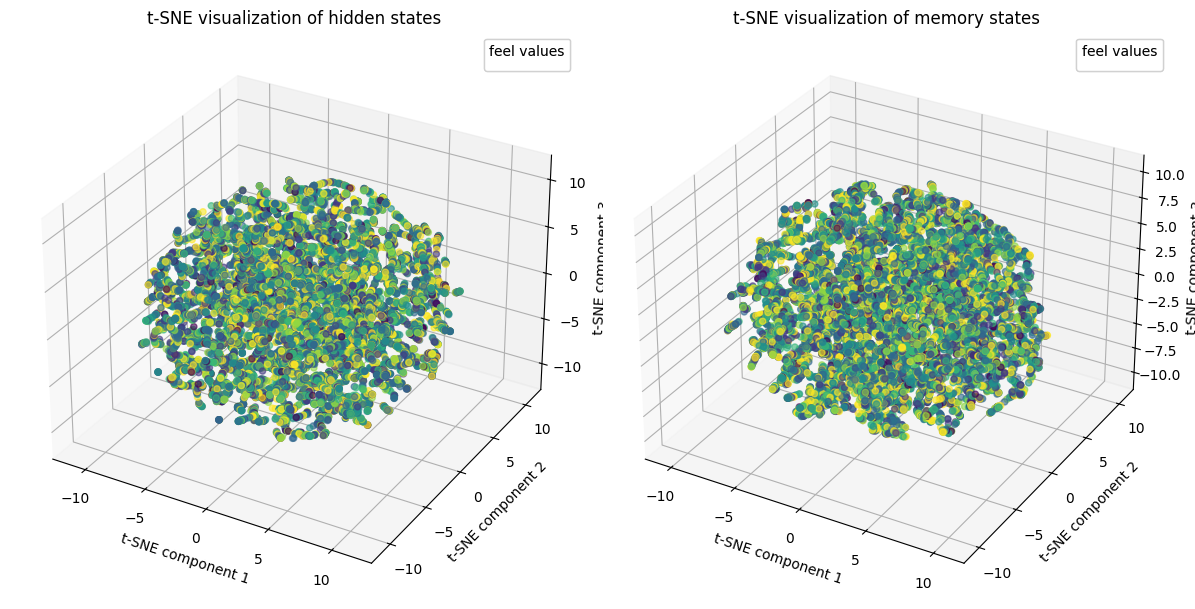

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_5086/336493527.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax1.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], all_output_emb_1[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
/tmp/ipykernel_5086/336493527.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax2.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], all_output_emb_2[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
/home/pe/Documents/stage/Dpt_transform

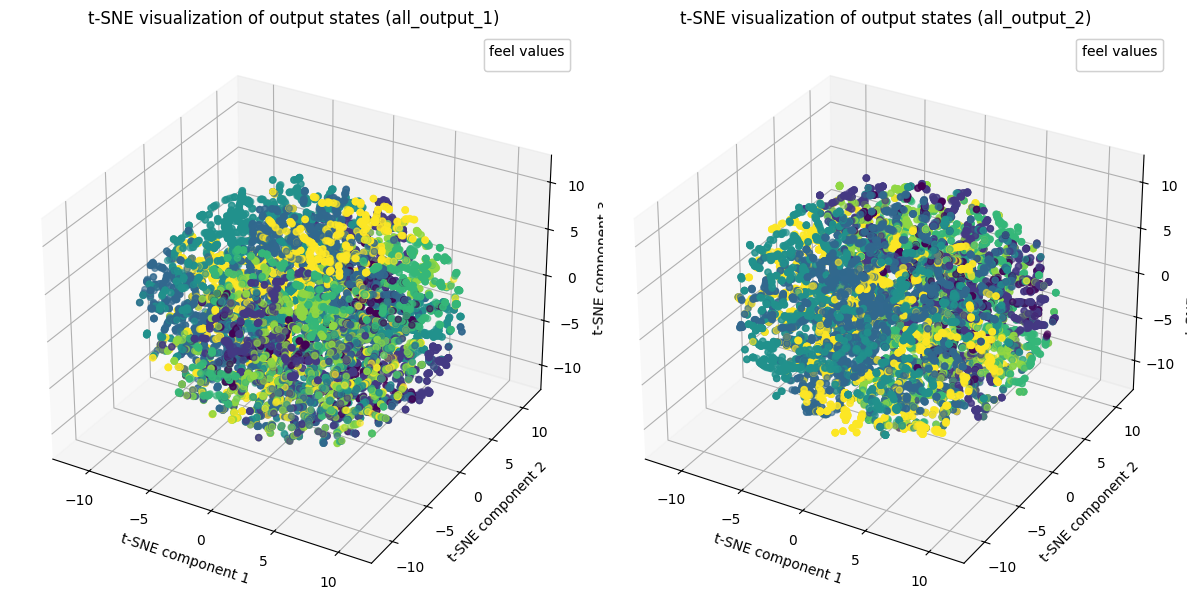

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Ajuster TSNE pour générer trois composants
tsne = TSNE(n_components=3, random_state=42, perplexity=5, n_iter=300)

# Transformer les données en embeddings 3D
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)

# Extraire les informations "feel" de data_infos

feel_info = [str(info[0]) + str(info[1]) + str(info[2]) for info in zip(data_infos_success["state_left"], data_infos_success["state_front"], data_infos_success["state_right"])]
unique_feel = np.unique(feel_info)
color_map = plt.cm.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]

# Créer les scatter plots 3D pour les embeddings
fig = plt.figure(figsize=(12, 6))

# Plot pour all_hidden_emb
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], all_hidden_emb[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE visualization of hidden states')
ax1.set_xlabel('t-SNE component 1')
ax1.set_ylabel('t-SNE component 2')
ax1.set_zlabel('t-SNE component 3')

# Plot pour all_mem_emb
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], all_mem_emb[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax2.set_title('t-SNE visualization of memory states')
ax2.set_xlabel('t-SNE component 1')
ax2.set_ylabel('t-SNE component 2')
ax2.set_zlabel('t-SNE component 3')

# Ajouter une légende pour les couleurs
legend1 = ax1.legend(*sc1.legend_elements(), title="feel values")
ax1.add_artist(legend1)
legend2 = ax2.legend(*sc2.legend_elements(), title="feel values")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()

# Pour les sorties all_output_1 et all_output_2
tsne = TSNE(n_components=3, random_state=42, perplexity=2, n_iter=300)

all_output_stack_1 = torch.stack(all_output_1)
all_output_stack_1 = all_output_stack_1.detach().cpu().numpy()
all_output_emb_1 = tsne.fit_transform(all_output_stack_1)

all_output_stack_2 = torch.stack(all_output_2)
all_output_stack_2 = all_output_stack_2.detach().cpu().numpy()
all_output_emb_2 = tsne.fit_transform(all_output_stack_2)

fig = plt.figure(figsize=(12, 6))

# Plot pour all_output_emb_1
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], all_output_emb_1[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE visualization of output states (all_output_1)')
ax1.set_xlabel('t-SNE component 1')
ax1.set_ylabel('t-SNE component 2')
ax1.set_zlabel('t-SNE component 3')

# Plot pour all_output_emb_2
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], all_output_emb_2[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax2.set_title('t-SNE visualization of output states (all_output_2)')
ax2.set_xlabel('t-SNE component 1')
ax2.set_ylabel('t-SNE component 2')
ax2.set_zlabel('t-SNE component 3')

# Ajouter une légende pour les couleurs
legend1 = ax1.legend(*sc1.legend_elements(), title="feel values")
ax1.add_artist(legend1)
legend2 = ax2.legend(*sc2.legend_elements(), title="feel values")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()


In [ ]:
raise "end"

TypeError: exceptions must derive from BaseException

# Not implemented

In [ ]:
input_seq = torch.tensor(tokenizer.encode(
    ['forward', 'empty', 'feel_right', 'empty', 'turn_left', 'empty', 'feel_front', 'empty', 'feel_front', 'empty', 'forward', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'forward', 'wall', 'turn_right', 'empty', 'turn_right', '<pad>']
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['forward', 'empty'] * 4
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))
1000
# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-2] = 'feel_front'
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['feel_left', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty']
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# Avec interaction

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


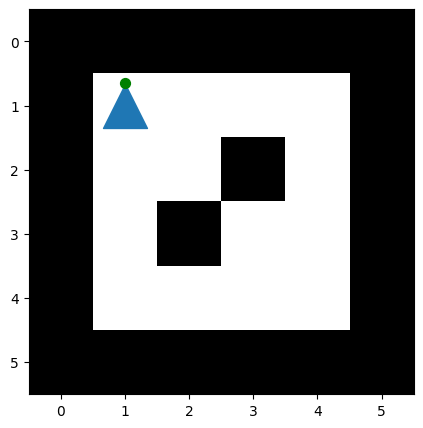

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_interaction.display_world()

In [ ]:
list_vocab = ['<pad>', '<mask>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
for act in env_interaction.get_actions():
    list_vocab.append(act)
for fb in env_interaction.get_outcomes():
        list_vocab.append(fb)
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)
for key, value in tokenizer_interaction.str_to_int.items():
    print(f"{key}: {value}")

<pad>: 0
<mask>: 1
('forward', 'wall'): 2
('forward', 'empty'): 3
('turn_left', 'wall'): 4
('turn_left', 'empty'): 5
('turn_right', 'wall'): 6
('turn_right', 'empty'): 7
('feel_front', 'wall'): 8
('feel_front', 'empty'): 9
('feel_left', 'wall'): 10
('feel_left', 'empty'): 11
('feel_right', 'wall'): 12
('feel_right', 'empty'): 13
forward: 14
turn_left: 15
turn_right: 16
feel_front: 17
feel_left: 18
feel_right: 19
wall: 20
empty: 21


In [ ]:
def get_data_interaction(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data.append(tokenizer.encode((action, feedback)))
    return data

In [ ]:
data_train_inter = []
for i in range(10):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=5))
print("data_train_inter", data_train_inter)
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))

data_train_inter [[7, 7, 11, 5, 7], [5, 5, 13, 7, 3], [13, 3, 9, 12, 9], [3, 5, 11, 8, 2], [2, 5, 12, 3, 3], [11, 11, 7, 8, 7], [13, 10, 9, 7, 9], [13, 7, 9, 11, 7], [8, 2, 7, 7, 7], [5, 11, 5, 7, 9]]
[('turn_right', 'empty'), ('turn_right', 'empty'), ('feel_left', 'empty'), ('turn_left', 'empty'), ('turn_right', 'empty')]
[('turn_left', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('turn_right', 'empty'), ('forward', 'empty')]
[('feel_right', 'empty'), ('forward', 'empty'), ('feel_front', 'empty'), ('feel_right', 'wall'), ('feel_front', 'empty')]
[('forward', 'empty'), ('turn_left', 'empty'), ('feel_left', 'empty'), ('feel_front', 'wall'), ('forward', 'wall')]
[('forward', 'wall'), ('turn_left', 'empty'), ('feel_right', 'wall'), ('forward', 'empty'), ('forward', 'empty')]
[('feel_left', 'empty'), ('feel_left', 'empty'), ('turn_right', 'empty'), ('feel_front', 'wall'), ('turn_right', 'empty')]
[('feel_right', 'empty'), ('feel_left', 'wall'), ('feel_front', 'empty'), ('tur

In [ ]:
class TokenDropInteraction(nn.Module):
    """For a batch of tokens indices, randomly replace a interaction token with action associated to it.
    """

    def __init__(self, tokenizer, prob=0.1, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.dic_remplacement = {}
        for key, value in tokenizer.str_to_int.items():
            if type(key) == tuple:
                self.dic_remplacement[value] = tokenizer.encode(key[0])
                
    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        for interaction, replacement in self.dic_remplacement.items():
            interaction_mask = (sample == interaction) & (mask == 1)
            sample = torch.where(interaction_mask, replacement, sample)
        
        return sample, mask

In [ ]:
td = TokenDropInteraction(tokenizer=tokenizer_interaction, prob=0.5, num_special=2)

data_train_inter[0][-1] = 0
data_target_inter, mask = td(torch.tensor(data_train_inter))
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))
    
print("version masker")
for seq in data_target_inter.tolist():
    print(tokenizer_interaction.decode(seq))

[('turn_right', 'empty'), ('turn_right', 'empty'), ('feel_left', 'empty'), ('turn_left', 'empty'), '<pad>']
[('turn_left', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('turn_right', 'empty'), ('forward', 'empty')]
[('feel_right', 'empty'), ('forward', 'empty'), ('feel_front', 'empty'), ('feel_right', 'wall'), ('feel_front', 'empty')]
[('forward', 'empty'), ('turn_left', 'empty'), ('feel_left', 'empty'), ('feel_front', 'wall'), ('forward', 'wall')]
[('forward', 'wall'), ('turn_left', 'empty'), ('feel_right', 'wall'), ('forward', 'empty'), ('forward', 'empty')]
[('feel_left', 'empty'), ('feel_left', 'empty'), ('turn_right', 'empty'), ('feel_front', 'wall'), ('turn_right', 'empty')]
[('feel_right', 'empty'), ('feel_left', 'wall'), ('feel_front', 'empty'), ('turn_right', 'empty'), ('feel_front', 'empty')]
[('feel_right', 'empty'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('feel_left', 'empty'), ('turn_right', 'empty')]
[('feel_front', 'wall'), ('forward', 'wall'), (

In [ ]:
data_set_interaction = SimpleDataSet(data_train_inter)

tensor([[ 7,  7, 11,  5,  0],
        [ 5,  5, 13,  7,  3],
        [13,  3,  9, 12,  9],
        [ 3,  5, 11,  8,  2],
        [ 2,  5, 12,  3,  3],
        [11, 11,  7,  8,  7],
        [13, 10,  9,  7,  9],
        [13,  7,  9, 11,  7],
        [ 8,  2,  7,  7,  7],
        [ 5, 11,  5,  7,  9]])


In [ ]:
def eval_inter(model, data_loader, tokenizer):
    acc = 0
    data_frame_seq_inter = pd.DataFrame({
        "seq": [""] * len(data_loader),
        "seq_dec": [""] * len(data_loader),
        "prediction": [""] * len(data_loader),
        "prediction_dec": [""] * len(data_loader),
        "reality": [""] * len(data_loader),
        "reality_dec": [""] * len(data_loader),
        "probability": [""] * len(data_loader),
        "good_prediction": [False] * len(data_loader),
        "info_in_seq": [False] * len(data_loader),
        "info_feel_left": [False] * len(data_loader),
        "info_feel_front": [False] * len(data_loader),
        "info_feel_right": [False] * len(data_loader),
        "coo_xy": [""] * len(data_loader),
        "theta": [-1] * len(data_loader),
        "state_left": [""] * len(data_loader),
        "state_front": [""] * len(data_loader),
        "state_right": [""] * len(data_loader)
    })

    with torch.no_grad():
        h = torch.zeros(model.num_layers * 2, 1, model.hidden_size).to(device)
        cell = torch.zeros(model.num_layers * 2, 1, model.hidden_size).to(device)
        for i, (input, target, info) in tqdm(enumerate(data_loader)):
            input = input.to(device)
            target = target.to(device)
            
            output, _, _ = model(input, h, cell)
            
            arrays, x, y, theta = process_sequence_inter(tokenizer.decode(input.tolist()[0]), 6, None)
            good_seq = info_in_memory(arrays)
            feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
            
            proba = F.softmax(output, dim=-1)
            output = output.transpose(1, 2)
            pred = output.argmax(dim=1)
            acc += (pred[-1][-1] == target).item()
            state_left = info["feel_left"][0]
            state_front = info["feel_front"][0]
            state_right = info["feel_right"][0]
            coo = (info["coo"][0].item(), info["coo"][1].item())
            theta = info["theta"][0].item()

            data_frame_seq_inter.loc[i] = [
                str(input.tolist()[0]),
                str(tokenizer.decode(input.tolist()[0])),
                str(pred.tolist()[0][-1]),
                str(tokenizer.decode(pred.tolist()[0][-1])),
                str(target.tolist()[0]),
                str(tokenizer.decode(target.tolist()[0])),
                str(proba.tolist()[-1][-1][-2:]),
                (pred[-1][-1] == target).item(),
                good_seq,
                feel_left,
                feel_front,
                feel_right,
                str(coo),
                theta,
                state_left,
                state_front,
                state_right
            ]
    
    return acc, data_frame_seq_inter

In [ ]:
def train_inter(model: nn.Module, 
            data_loader_train: DataLoader, data_loader_validation: DataLoader,
            nb_epoch: int, tokenizer:SimpleTokenizerV1,
            optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td = TokenDropInteraction(
        prob=pourcentTokenDrop,
        tokenizer=tokenizer,
        num_special=2)

    model.train()
    list_acc = []
    list_validation = []
    list_loss = []
    for epoch in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        model.train()
        for i, data in enumerate(data_loader_train):
            data_mask, mask = td(data)
            # print("data_mask", data_mask)
            # for seq in data_mask.tolist():
            #     print(tokenizer_interaction.decode(seq))
            bs = data.shape[0]

            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size).to(device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size).to(device)
            
            data_mask = data_mask.to(device)
            data = data.to(device)
                        
            proba, hidden, memory = model(data_mask, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (mask == 0)
            
            pad_mask = pad_mask.to(device)
            pred = pred.to(device)
            mask = mask.to(device)
            # pred_in_seq = pred * pad_mask + 0 * mask
            
            # Mettre <pad> pour les tokens non masqués
            # pred_in_seq = pred_in_seq.masked_fill(pad_mask, tokenizer.encode("<pad>"))
            # print("proba", proba.shape)
            # print("pad_mask", pad_mask.shape)
            # pad_mask pass shape [bs, context_size] to [bs, num_emb ,context_size]
            # pad_mask = pad_mask.unsqueeze(1).expand(-1, proba.shape[1], -1)
            # print("pad_mask", pad_mask.shape)
            # prob_without_mask = proba.masked_fill(pad_mask, tokenizer.encode("<pad>"))
            # print("prob_without_mask", prob_without_mask)
            
            correct = (pred == data)
            # print("pred", pred)
            # for seq in pred.tolist():
            #     print(tokenizer_interaction.decode(seq))
            # print("data", data)
            # for seq in data.tolist():
            #     print(tokenizer_interaction.decode(seq))

            
            acc = correct.sum() / (correct.shape[0] * correct.shape[1])
            # acc2 = correct.sum() / (correct.shape[0] * correct.shape[1])
            # acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if data_loader_validation is not None:
            model.eval()
            acc_val, _ = eval_inter(model, data_loader_validation, tokenizer)
            acc_val = acc_val / len(data_loader_validation)
            list_validation.append(acc_val)
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {epoch + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
        
    return list_acc, list_loss, list_validation

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>', '<mask>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
for act in env_interaction.get_actions():
    list_vocab.append(act)
for fb in env_interaction.get_outcomes():
        list_vocab.append(fb)
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)

dic_remplacement = {}
for key, value in tokenizer_interaction.str_to_int.items():
    if type(key) == tuple:
        dic_remplacement[value] = tokenizer_interaction.encode(key[0])

data_train_inter = []
for i in range(10000):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=50))
data_set_interaction = SimpleDataSet(data_train_inter)
data_loader_interaction = DataLoader(data_set_interaction, batch_size=16, shuffle=True)

hidden_size = 1024
num_layers = 1
model_inter = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.15
)

model_inter.to(device)

optimizer_inter = optim.Adam(model_inter.parameters(), lr=0.001)
loss_fn_inter = nn.CrossEntropyLoss(ignore_index=tokenizer_interaction.encode("<pad>"))

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
tensor([[ 5,  8, 11,  ...,  7,  5,  3],
        [ 9, 12, 12,  ...,  7, 10,  9],
        [ 5,  2,  7,  ..., 12,  7, 11],
        ...,
        [ 2,  8,  5,  ...,  8,  8,  2],
        [11,  2, 12,  ...,  9,  3, 10],
        [ 9, 12,  5,  ...,  5,  5, 11]])


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn(


In [ ]:
list_acc, list_loss, list_val = train_inter(
    model=model_inter,
    data_loader_train=data_loader_interaction, data_loader_validation=data_loader_test_inter,
    nb_epoch=50,
    tokenizer=tokenizer_interaction,
    optimizer=optimizer_inter,
    loss_fn=loss_fn_inter,
    pourcentTokenDrop=0.15
)

Training :   0%|          | 0/50 [00:00<?, ?epoch/s]

0it [00:00, ?it/s]

Epoch 1/50, Loss: 1.284885298460722, Accuracy: 0.7049999833106995


0it [00:00, ?it/s]

Epoch 2/50, Loss: 0.10847832635045052, Accuracy: 0.9653124809265137


0it [00:00, ?it/s]

Epoch 3/50, Loss: 0.06366413924843073, Accuracy: 0.9709374904632568


0it [00:00, ?it/s]

Epoch 4/50, Loss: 0.06793078780174255, Accuracy: 0.9724999666213989


0it [00:00, ?it/s]

Epoch 5/50, Loss: 0.0751104112714529, Accuracy: 0.9631249904632568


0it [00:00, ?it/s]

Epoch 6/50, Loss: 0.048577677458524704, Accuracy: 0.9778124690055847


0it [00:00, ?it/s]

Epoch 7/50, Loss: 0.04995138943195343, Accuracy: 0.9759374856948853


0it [00:00, ?it/s]

Epoch 8/50, Loss: 0.04714903887361288, Accuracy: 0.9806249737739563


0it [00:00, ?it/s]

Epoch 9/50, Loss: 0.04091522190719843, Accuracy: 0.9800000190734863


0it [00:00, ?it/s]

Epoch 10/50, Loss: 0.04697122052311897, Accuracy: 0.9771875143051147


0it [00:00, ?it/s]

Epoch 11/50, Loss: 0.040259101428091526, Accuracy: 0.9778124690055847


0it [00:00, ?it/s]

Epoch 12/50, Loss: 0.05487352795898914, Accuracy: 0.9778124690055847


0it [00:00, ?it/s]

Epoch 13/50, Loss: 0.048894239123910666, Accuracy: 0.9746875166893005


0it [00:00, ?it/s]

Epoch 14/50, Loss: 0.059105769731104374, Accuracy: 0.9753124713897705


0it [00:00, ?it/s]

Epoch 15/50, Loss: 0.03897927387151867, Accuracy: 0.9824999570846558


0it [00:00, ?it/s]

Epoch 16/50, Loss: 0.05534725543111563, Accuracy: 0.9740625023841858


0it [00:00, ?it/s]

Epoch 17/50, Loss: 0.049083990044891834, Accuracy: 0.9765625


0it [00:00, ?it/s]

Epoch 18/50, Loss: 0.03227494168095291, Accuracy: 0.9859374761581421


0it [00:00, ?it/s]

Epoch 19/50, Loss: 0.031427355483174324, Accuracy: 0.9846874475479126


0it [00:00, ?it/s]

Epoch 20/50, Loss: 0.0333075518719852, Accuracy: 0.9828124642372131


0it [00:00, ?it/s]

Epoch 21/50, Loss: 0.037496300879865885, Accuracy: 0.9806249737739563


0it [00:00, ?it/s]

Epoch 22/50, Loss: 0.029355449602007866, Accuracy: 0.9868749976158142


0it [00:00, ?it/s]

Epoch 23/50, Loss: 0.04293034644797444, Accuracy: 0.97718745470047


0it [00:00, ?it/s]

Epoch 24/50, Loss: 0.029273647349327803, Accuracy: 0.9856249690055847


0it [00:00, ?it/s]

Epoch 25/50, Loss: 0.04653990361839533, Accuracy: 0.9768750071525574


0it [00:00, ?it/s]

Epoch 26/50, Loss: 0.029326183954253793, Accuracy: 0.9878124594688416


0it [00:00, ?it/s]

Epoch 27/50, Loss: 0.030817123129963875, Accuracy: 0.9859374761581421


0it [00:00, ?it/s]

Epoch 28/50, Loss: 0.039893255569040775, Accuracy: 0.9834374785423279


0it [00:00, ?it/s]

Epoch 29/50, Loss: 0.04514080425724387, Accuracy: 0.9787499904632568


0it [00:00, ?it/s]

Epoch 30/50, Loss: 0.038021259708330035, Accuracy: 0.9815624952316284


0it [00:00, ?it/s]

Epoch 31/50, Loss: 0.04032990802079439, Accuracy: 0.9818750023841858


0it [00:00, ?it/s]

Epoch 32/50, Loss: 0.02165522240102291, Accuracy: 0.9909374713897705


0it [00:00, ?it/s]

Epoch 33/50, Loss: 0.032331859692931175, Accuracy: 0.9865624904632568


0it [00:00, ?it/s]

Epoch 34/50, Loss: 0.04076220374554396, Accuracy: 0.9781249761581421


0it [00:00, ?it/s]

Epoch 35/50, Loss: 0.0195064852014184, Accuracy: 0.9925000071525574


0it [00:00, ?it/s]

Epoch 36/50, Loss: 0.03357933089137077, Accuracy: 0.9853124618530273


0it [00:00, ?it/s]

Epoch 37/50, Loss: 0.02643899992108345, Accuracy: 0.9906250238418579


0it [00:00, ?it/s]

Epoch 38/50, Loss: 0.0333922915160656, Accuracy: 0.9871874451637268


0it [00:00, ?it/s]

Epoch 39/50, Loss: 0.030073925852775574, Accuracy: 0.9856249690055847


0it [00:00, ?it/s]

Epoch 40/50, Loss: 0.026933050714433193, Accuracy: 0.987500011920929


0it [00:00, ?it/s]

Epoch 41/50, Loss: 0.028458744287490845, Accuracy: 0.9881250262260437


0it [00:00, ?it/s]

Epoch 42/50, Loss: 0.03138769464567304, Accuracy: 0.9868749976158142


0it [00:00, ?it/s]

Epoch 43/50, Loss: 0.03722561802715063, Accuracy: 0.9840624332427979


0it [00:00, ?it/s]

Epoch 44/50, Loss: 0.042377945967018604, Accuracy: 0.9803124666213989


0it [00:00, ?it/s]

Epoch 45/50, Loss: 0.028098688926547766, Accuracy: 0.9865624904632568


0it [00:00, ?it/s]

Epoch 46/50, Loss: 0.033872668631374836, Accuracy: 0.9818750023841858


0it [00:00, ?it/s]

Epoch 47/50, Loss: 0.02744330419227481, Accuracy: 0.987500011920929


0it [00:00, ?it/s]

Epoch 48/50, Loss: 0.03554179961793125, Accuracy: 0.9887499809265137


0it [00:00, ?it/s]

Epoch 49/50, Loss: 0.024716870859265327, Accuracy: 0.9896875023841858


0it [00:00, ?it/s]

Epoch 50/50, Loss: 0.032873187214136124, Accuracy: 0.9871875047683716


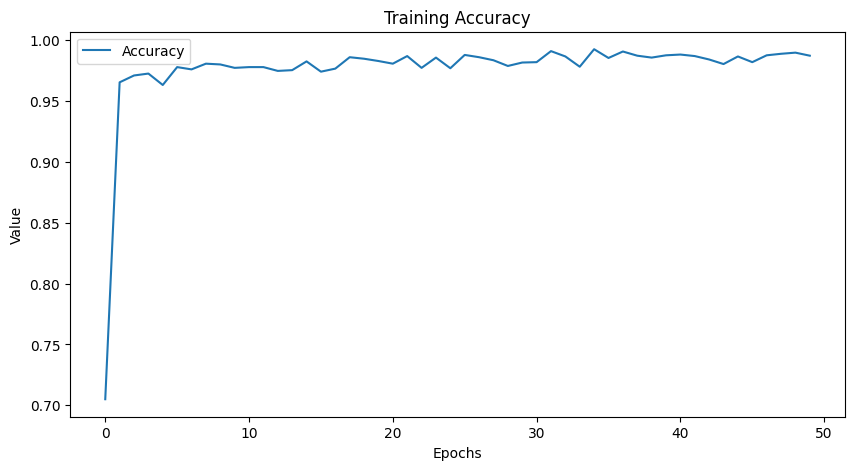

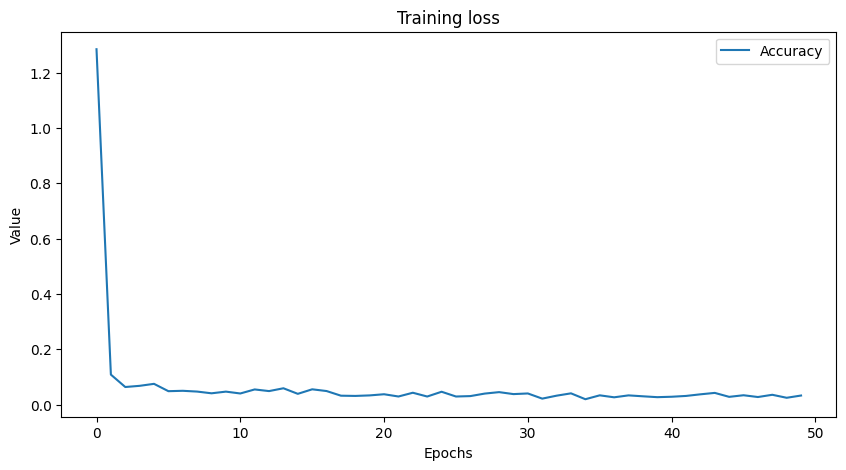

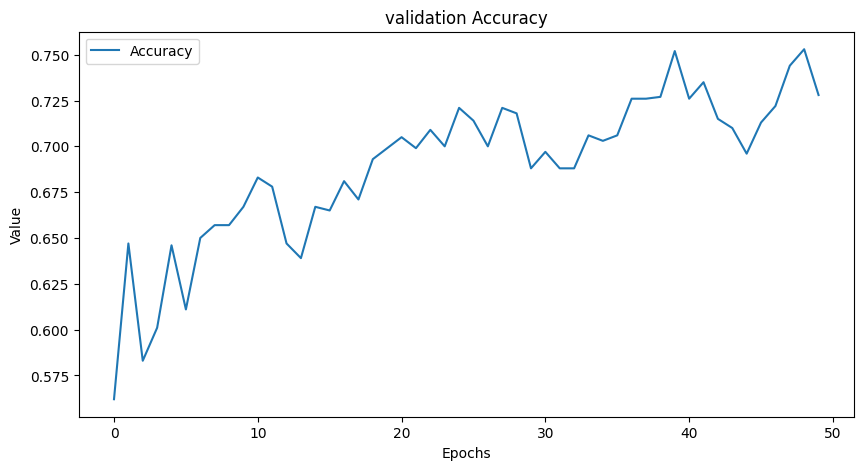

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
list_acc = torch.tensor(list_acc).cpu()
plt.plot(list_acc, label='Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(list_loss, label='Accuracy')
plt.title('Training loss')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
plt.plot(list_val, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('validation Accuracy')
plt.legend()
plt.show()

In [ ]:
env_test_inter = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x_inter = []
data_test_y_inter = []
data_infos_inter = []
for i in range(1000):
    # range_context = np.random.randint(10, 20)
    range_context = 20
    last_inter =  ('turn_right', 'empty')
    while last_inter ==  ('turn_right', 'empty') or last_inter ==  ('turn_left', 'empty'):
        sequence = get_data_interaction(env_test_inter, tokenizer_interaction, n_episodes=range_context)
        last_inter = tokenizer_interaction.decode(sequence[-1])
        
    # print("last_inter", last_inter)
    # print("sequence", tokenizer_interaction.decode(sequence))
    
           
    data_test_y_inter.append(sequence[-1])
    data_test_x_inter.append(sequence[:-1] + [dic_remplacement[sequence[-1]]])
    
    # print("data_test_x", data_test_x_inter)
    # print("data_test_x", tokenizer_interaction.decode(data_test_x_inter[-1]))

    
    data_infos_inter.append({
        "sequence": sequence,
        "coo": env_test_inter.get_coo(),
        "theta": env_test_inter.get_theta(),
        "last_inter": last_inter,
        "info_in_sequence": bool(info_in_seq(tokenizer_interaction.decode(data_test_x_inter[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test_inter.outcome(feel)
        data_infos_inter[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y_inter:
    if i == 8:
        count_8 += 1
    elif i == 9:
        count_7 += 1
print(f"count_8 {tokenizer_interaction.decode(8)}", count_8)
print(f"count_7 {tokenizer_interaction.decode(9)}", count_7)

print("data_infos", data_infos_inter[0])
print("x ", data_test_x_inter[0])
print("y ", data_test_y_inter[0])

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
count_8 ('feel_front', 'wall') 133
count_7 ('feel_front', 'empty') 133
data_infos {'sequence': [7, 7, 11, 12, 9, 11, 3, 9, 5, 5, 7, 11, 5, 7, 9, 5, 3, 5, 11, 2], 'coo': (1, 1), 'theta': 3, 'last_inter': ('forward', 'wall'), 'info_in_sequence': True, 'feel_front': 'wall', 'feel_left': 'empty', 'feel_right': 'wall'}
x  [7, 7, 11, 12, 9, 11, 3, 9, 5, 5, 7, 11, 5, 7, 9, 5, 3, 5, 11, 14]
y  2


In [ ]:
class CustomDataSetInfo(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

In [ ]:
length = max(len(xi) for xi in data_test_x_inter)
data_test_x_tensor_inter = torch.zeros((len(data_test_x_inter), length), dtype=torch.long)
for i, xi in enumerate(data_test_x_inter):
    data_test_x_tensor_inter[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor_inter = torch.tensor(data_test_y_inter, dtype=torch.long)

data_loader_test_inter = DataLoader(CustomDataSetInfo(data_test_x_tensor_inter, data_test_y_tensor_inter, data_infos_inter), batch_size=1, shuffle=False)

for i, (data_x, data_y, info) in enumerate(data_loader_test_inter):
    print(data_x)
    print(data_y)
    for key, value in info.items():
        print(f"{key}: {value}")
    break

tensor([[ 7,  7, 11, 12,  9, 11,  3,  9,  5,  5,  7, 11,  5,  7,  9,  5,  3,  5,
         11, 14]])
tensor([2])
sequence: [tensor([7]), tensor([7]), tensor([11]), tensor([12]), tensor([9]), tensor([11]), tensor([3]), tensor([9]), tensor([5]), tensor([5]), tensor([7]), tensor([11]), tensor([5]), tensor([7]), tensor([9]), tensor([5]), tensor([3]), tensor([5]), tensor([11]), tensor([2])]
coo: [tensor([1]), tensor([1])]
theta: tensor([3])
last_inter: [('forward',), ('wall',)]
info_in_sequence: tensor([True])
feel_front: ['wall']
feel_left: ['empty']
feel_right: ['wall']


In [ ]:
acc, data_frame_seq_inter = eval_inter(model_inter, data_loader_test_inter, tokenizer_interaction)
print(f"Accuracy: {acc / 1000}")

0it [00:00, ?it/s]

Accuracy: 0.017
